#🚗 ASSIGNMENT 4 🔋

We have a vehicle which needs to pass a known test track. You are given values $Preq(t)$ for each time $t=1,...,T$ which the vehicle's wheels needs to exert in order to successfully pass this test track.

The vehicle has a combustion engine, a motor/generator connected to a battery, and a friction break. Motor/generator can act either as a motor when it uses energy stored in the battery to power the wheels, or as a generator when it extracts the power from the wheels (regenerative breaking) or the engine to store it in the battery.

$Preq(t)$ is positive when the wheels need power, e.g. vehicle is ascending a hill or accelerating: power for the wheels needs to be provided by the combustion engine and/or the motor/generator which extracts the power stored in the battery. When $Preq(t)$ is negative (e.g. because vehicle is descending a hill), the power is extracted by the motor/generator which can store it in the battery and/or by the friction break.

Power is conserved, i.e., at each time $t$, we have
$Preq(t) = Peng(t) + Pmg(t) - Pbr(t)$
where $0≤Peng(t)≤Peng_{max}$ is power produced by the combustion engine, $Pmg_{min} ≤ Pmg(t) ≤ Pmg_{max}$ is power produced by the motor/generator (can be also negative if motor/generator absorbs power to charge the battery) and $Pbr(t)≥0$ is the power absorbed by the friction break. See data bellow for the definition of the constants.

For every $t=1,...,T+1$, the energy $E(t)$ in the battery has to be between $0$ and $Ebatt_{max}$ representing the power stored in empty and full battery respectively. Moreover, we need to take into account the charging and discharging of the battery: we have
$E(t+1) = E(t) - Pmg(t) - η|Pmg(t)|, for t=1,...,T,$
see variable eta in the data. The term with coefficient η represents the energy lost due to the inefficiency of the battery and motor/generator. We also require $E(T+1)=E(1)$ to make a fair comparison with a non-hybrid vehicle which has no battery.

The objective is to minimize the total fuel consumption of the vehicle over time, where the consumption at time $t$ is given by formula $Peng(t) + γ(Peng(t))^2$, i.e., a quadratic function. See data for the value of $γ$.

###Task 1: formulate this minimization problem as a convex program (10 points)
It is almost convex, just one set of constraints is problematic. Hint: Try to relax it, only one inequality is important, but provide an explanation (e.g. in the comments of your code) why your formulation is equivalent.

###Task 2: solve your convex program with cvxpy library (10 points)
Link to the library: https://www.cvxpy.org/. Present the solution using a clear and well explained plot generated by matplotlib which was also used in the previous assignment.

###Task 3: comparison with a battery-less car (5 points)
Change $Ebatt_{max}$ to $0$ and solve your program again to see how does it affect the power consumption.

###Task 4: handle glitches (5 points)
You may find out that although your program is equivalent, the solution found by the solver does not fulfill all the relaxed constraints with equality. This might happen during long periods of breaking when there is a lot of opportunities to charge the battery and sometimes the solver may decide to waste part of the power available to charge the battery (because it may charge it fully in the following time steps). There are two options how to proceed:

- Postprocess the solution to get another solution with the same objective value where the relaxed constraints are preserved with equality. Such solution must exist since your program is equivalent to the original one. Hint: just move all the power from motor/generator to the battery and, if the battery is full, move it to the friction break.

- Add a small term to the objective which will discourage such situation: for every $t=1,...,T$, you can add a term $ε·max(0, -Pmg(t))$ for some small positive $ε$ in order to discourage absorbing power by the motor/generator if it is not going to be used for charging the battery (because it is cheaper to absorb the power using the friction break)
In case you decide to modify the objective, compare the power consumption achieved by your program to the power consumption achieved by the program with the original objective (to show that they are very similar with your choice of $ε$.

###Data
Include the following code in your solution which generates data for you. The array Preq contains power requirements in all time steps. Bellow, are the bounds specifying the parameters of the engine, motor/generator, capacity of the battery, coefficient eta of the inefficiency of charging/discharging and coefficient gamma in the objective function.

```
import numpy as np
a=[0.5, -0.5, 0.2, -0.7, 0.6, -0.2, 0.7, -0.5, 0.8, -0.4]
l=[40, 20, 40, 40, 20, 40, 30, 40, 30, 60]
Preq=np.arange(a[0],a[0]*(l[0]+0.5),a[0])

for i in range(1, len(l)):
    Preq=np.r_[ Preq, np.arange(Preq[-1]+a[i],Preq[-1]+a[i]*(l[i]+0.5),a[i]) ]

T = sum(l)

Peng_max = 20.0
Pmg_min = -6.0
Pmg_max = 6.0
Ebatt_max = 100.0
eta = 0.1
gamma = 0.1
```

####A note on precision
LP solvers which we used so far always provided a precise feasible solutions. This is not always the case with the solvers for convex optimization. If you want better precision, see "eps" parameters in Solver options. However, default values are good enough for the purpose of this assignment.


In [ ]:
import cvxpy as cp
#Generating the data

import numpy as np
a=[0.5, -0.5, 0.2, -0.7, 0.6, -0.2, 0.7, -0.5, 0.8, -0.4]
l=[40, 20, 40, 40, 20, 40, 30, 40, 30, 60]
Preq=np.arange(a[0],a[0]*(l[0]+0.5),a[0])

for i in range(1, len(l)):
    Preq=np.r_[ Preq, np.arange(Preq[-1]+a[i],Preq[-1]+a[i]*(l[i]+0.5),a[i]) ]

T = sum(l)


Peng_max = 20.0
Pmg_min = -6.0
Pmg_max = 6.0
Ebatt_max = 100.0
eta = 0.1
gamma = 0.1

As stated in the problem, we should handle the problematic constraint. In that case, it is the one with the absolute value in it. In fact, it is a non-convex constraint. We handle this problem substituting it with the two inequalities you can find in the code. This substitution is equivalent using the property of the absolute value : |X| < Y == -Y < X < Y . This relaxation could be interpreted as the fact that we leave the chance of throwing away energy at the battery at each step. Besides the fact that it could sounds bad, we see that since our aim is to minimize the fuel consumption, the problem will continue to try to make this constraint tight, solving indeed this little "inconsistency"

In [ ]:
# Starting the problem
peng = cp.Variable(360)
pmg = cp.Variable(360)
pbr = cp.Variable(360)
ebatt = cp.Variable(361)
cost = 0
constr = []

constr += [ebatt[360] == ebatt[0]]

for i in range(T):
  
  constr += [ Preq[i] == peng[i] + pmg[i] - pbr[i],
                           pmg[i] >= Pmg_min,
                           pmg[i] <= Pmg_max,
                           peng[i] >= 0,
                           peng[i] <= Peng_max,
                           ebatt[i] <= Ebatt_max,
                           ebatt[i] >= 0,
                           pbr[i] >= 0,
                           eta*pmg[i] <= ebatt[i] - pmg[i] - ebatt[i+1],
                           ebatt[i+1] - ebatt[i] + pmg[i] <= eta*pmg[i]
                          
                           ]
   
  cost += ((cp.sum_squares(peng[i])*gamma) + ((peng[i])))
  


     
problem = cp.Problem(cp.Minimize(cost), constr)
problem.solve()

task1 = problem.value

In [ ]:
print ( 'optimal value for the electric car:', task1)

optimal value for the electric car: 5077.52537124222


Let's do the plot

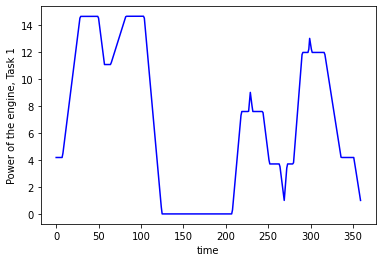

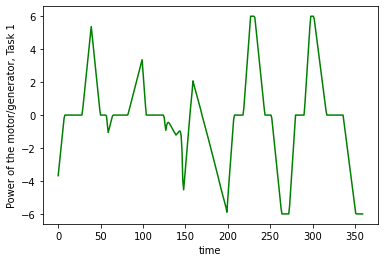

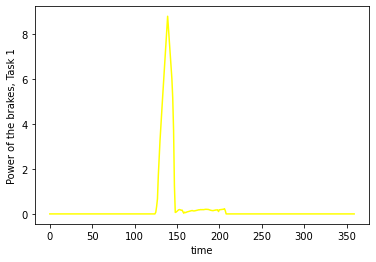

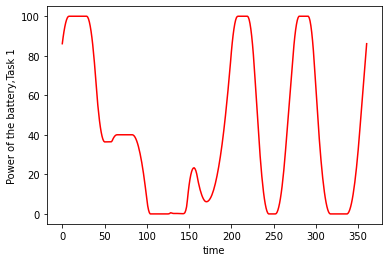

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import datetime
# create data
results = [peng.value,pmg.value, pbr.value ]
names = ['Power of the engine, Task 1', 'Power of the motor/generator, Task 1' , 'Power of the brakes, Task 1', 'Power of the battery,Task 1']
colors = ['blue', 'green', 'yellow', 'red']


x = [i for i in range(360)]
for i in range(len(results)):
  
  plt.plot(x,results[i], color = colors[i])
  plt.ylabel(names[i])
  plt.xlabel('time')


  plt.show()
plt.plot([j for j in range(361)],ebatt.value, color = colors[3])
plt.ylabel(names[3])
plt.xlabel('time')
plt.show()




Now all in the same plot

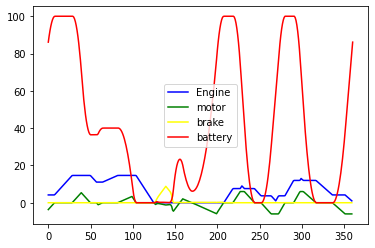

In [ ]:
plt.plot(x, peng.value, label = "Engine", color = 'blue')
plt.plot(x, pmg.value, label = "motor",color = 'green')
plt.plot(x, pbr.value, label = "brake",color = 'yellow')
plt.plot([j for j in range(361)], ebatt.value, label = "battery",color = 'red')
plt.legend()
plt.show()


Now let's handle the case where we have no battery

In [ ]:
# Starting the problem
peng = cp.Variable(360)
pmg = cp.Variable(360)
pbr = cp.Variable(360)
ebatt = cp.Variable(361)
cost = 0
constr = []

constr += [ebatt[360] == ebatt[0]]

for i in range(T):
  
  constr += [ Preq[i] == peng[i] + pmg[i] - pbr[i],
                           pmg[i] >= Pmg_min,
                           pmg[i] <= Pmg_max,
                           peng[i] >= 0,
                           peng[i] <= Peng_max,
                           ebatt[i] == 0,
                           #ebatt[i] >= 0,
                           pbr[i] >= 0,
                           eta*pmg[i] <= ebatt[i] - pmg[i] - ebatt[i+1],
                           ebatt[i+1] - ebatt[i] + pmg[i] <= eta*pmg[i]
                          # ebatt[i+1] >= (-eta*pmg[i] - ebatt[i] + pmg[i]),
                           #ebatt[i+1] >=  (eta*pmg[i] + ebatt[i] - pmg[i]),
                          # ebatt[i+1] <= (eta*pmg[i] + ebatt[i] - pmg[i]),
                           #ebatt[i+1] <= (-eta*pmg[i] - ebatt[i] + pmg[i]),
                           ]
   
  cost += ((cp.sum_squares(peng[i])*gamma) + ((peng[i])))
  


     
problem = cp.Problem(cp.Minimize(cost), constr)
problem.solve()

task2 = problem.value

In [ ]:
print ( 'optimal value for the non-electric car:', task2)

optimal value for the non-electric car: 5896.809012309291


Plot in the case where we have no battery

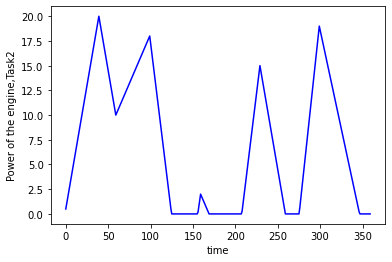

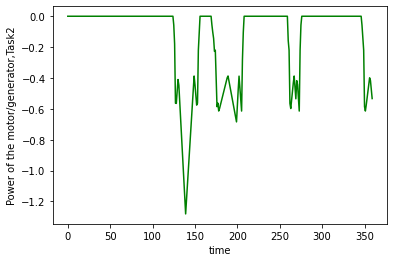

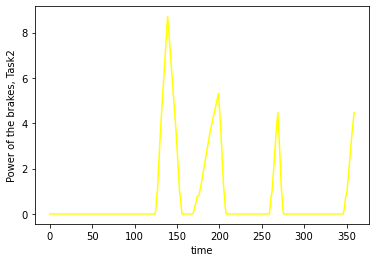

<function matplotlib.pyplot.plot>

In [ ]:
results = [peng.value,pmg.value, pbr.value ]
names = ['Power of the engine,Task2', 'Power of the motor/generator,Task2' , 'Power of the brakes, Task2', 'Power of the battery,Task2']
colors = ['blue', 'green', 'yellow', 'red']

x = [i for i in range(360)]
for i in range(len(results)):
  #plt.rcParams["figure.figsize"] = (4, 4)
  plt.plot(x,results[i], color = colors[i])
  plt.ylabel(names[i])
  plt.xlabel('time')
  #plt.xlim([0,370])
  #plt.ylim([0,100])
  plt.show()

# plot
#for i in range(T):

#plt.gcf().autofmt_xdate()
plt.plot


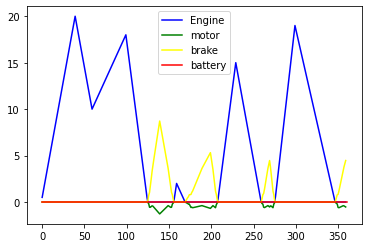

In [ ]:
plt.plot(x, peng.value, label = "Engine", color = 'blue')
plt.plot(x, pmg.value, label = "motor",color = 'green')
plt.plot(x, pbr.value, label = "brake",color = 'yellow')
plt.plot([j for j in range(361)], ebatt.value, label = "battery",color = 'red')
plt.legend()
plt.show()

Now let's handle glitches

In [ ]:
# Starting the problem
peng = cp.Variable(360)
pmg = cp.Variable(360)
pbr = cp.Variable(360)
ebatt = cp.Variable(361)
cost = 0
constr = []

constr += [ebatt[360] == ebatt[0]]

for i in range(T):
  
  constr += [ Preq[i] == peng[i] + pmg[i] - pbr[i],
                           pmg[i] >= Pmg_min,
                           pmg[i] <= Pmg_max,
                           peng[i] >= 0,
                           peng[i] <= Peng_max,
                           ebatt[i] <= Ebatt_max,
                           ebatt[i] >= 0,
                           pbr[i] >= 0,
                           eta*pmg[i] <= ebatt[i] - pmg[i] - ebatt[i+1],
                           ebatt[i+1] - ebatt[i] + pmg[i] <= eta*pmg[i]
                          # ebatt[i+1] >= (-eta*pmg[i] - ebatt[i] + pmg[i]),
                           #ebatt[i+1] >=  (eta*pmg[i] + ebatt[i] - pmg[i]),
                          # ebatt[i+1] <= (eta*pmg[i] + ebatt[i] - pmg[i]),
                           #ebatt[i+1] <= (-eta*pmg[i] - ebatt[i] + pmg[i]),
                           ]

  cost += (((cp.sum_squares(peng[i])*gamma) + ((peng[i]))) + 0.000001*(cp.maximum(0,-pmg[i])))
  


     
problem = cp.Problem(cp.Minimize(cost), constr)
problem.solve()



task3 = problem.value




In [ ]:
print ( 'obj value when we add the penalty in electric car', task3)

obj value when we add the penalty in electric car 5077.526510189411


In [ ]:
print('difference between objectives:', task1 - task3)

difference between objectives: -0.0011389471910661086


Here we see that the difference between the actual objective and the one before, with the case with battery.

now let's handle glitches in the case with no battery

In [ ]:
# Starting the problem
peng = cp.Variable(360)
pmg = cp.Variable(360)
pbr = cp.Variable(360)
ebatt = cp.Variable(361)
cost = 0
constr = []

constr += [ebatt[360] == ebatt[0]]

for i in range(T):
  
  constr += [ Preq[i] == peng[i] + pmg[i] - pbr[i],
                           pmg[i] >= Pmg_min,
                           pmg[i] <= Pmg_max,
                           peng[i] >= 0,
                           peng[i] <= Peng_max,
                           ebatt[i] == 0,
                           #ebatt[i] >= 0,
                           pbr[i] >= 0,
                           eta*pmg[i] <= ebatt[i] - pmg[i] - ebatt[i+1],
                           ebatt[i+1] - ebatt[i] + pmg[i] <= eta*pmg[i]
                          # ebatt[i+1] >= (-eta*pmg[i] - ebatt[i] + pmg[i]),
                           #ebatt[i+1] >=  (eta*pmg[i] + ebatt[i] - pmg[i]),
                          # ebatt[i+1] <= (eta*pmg[i] + ebatt[i] - pmg[i]),
                           #ebatt[i+1] <= (-eta*pmg[i] - ebatt[i] + pmg[i]),
                           ]
   
  cost += (((cp.sum_squares(peng[i])*gamma) + ((peng[i]))) + 0.001*(cp.maximum(0,-pmg[i])))
  


     
problem = cp.Problem(cp.Minimize(cost), constr)
problem.solve()

task4 = problem.value

In [ ]:
print( 'obj value when we add the penalty in non electric car:', task4)

obj value when we add the penalty in non electric car: 5896.809000000552


In [ ]:
print('difference between objectives in non-electric car', task1 - task3)

difference between objectives in non-electric car -0.0011389471910661086
